In [52]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import itertools
import nltk
import stats
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from autocorrect import Speller
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
from contractions import CONTRACTION_MAP
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [53]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\test.csv")

In [54]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [55]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [56]:
temp = train_data.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet
0,0,5894
1,1,2026


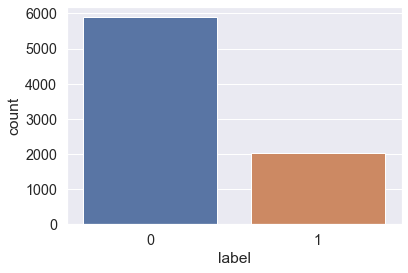

In [57]:
sns.countplot(x='label',data=train_data)

In [58]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [59]:
train_data['tweet']=train_data['tweet'].apply(expand_contractions)
test_data['tweet']=test_data['tweet'].apply(expand_contractions)

In [60]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I am wired I know I am George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple will not even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [61]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def split_words(self,input_text):
        return ''.join(re.findall('[A-Z][^A-Z]*', input_text))
    
    def standardize_words(self,input_text):
        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    '''def correct_spell(self,input_text):
        words = input_text.split() 
        clean_words = [str(TextBlob(word).correct()) for word in words] 
        return " ".join(clean_words)'''
    
    """def correct_spell(self,input_text):
        words = input_text.split() 
        spell = Speller(lang='en') 
        correct_words = [spell(word) for word in words] 
        return " ".join(correct_words) """
    '''def remove_meaningless(self,input_text):
        words = set(nltk.corpus.words.words())
        return " ".join(w for w in nltk.wordpunct_tokenize(input_text) if w.lower() in words or not w.isalpha())'''
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.split_words).apply(self.standardize_words).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [62]:
ct = CleanText()
train_data['tweet'] = ct.fit_transform(train_data.tweet)
test_data['tweet']=ct.fit_transform(test_data.tweet)

In [63]:
## Number of words in the original_text ##
train_data["num_words"] = train_data["tweet"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["tweet"].apply(lambda x: len(str(x).split()))

## Number of unique words in the original_text ##
train_data["num_unique_words"] = train_data["tweet"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["tweet"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the original_text ##
train_data["num_chars"] = train_data["tweet"].apply(lambda x: len(str(x)))
test_data["num_chars"] = test_data["tweet"].apply(lambda x: len(str(x)))

## Number of stopwords in the original_text ##
train_data["num_stopwords"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_data["num_stopwords"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the original_text ##
train_data["num_punctuations"] =train_data['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data["num_punctuations"] =test_data['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the original_text ##
train_data["num_words_upper"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_data["num_words_upper"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the original_text ##
train_data["num_words_title"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_data["num_words_title"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the original_text ##
train_data["mean_word_len"] = train_data["tweet"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data["mean_word_len"] = test_data["tweet"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [64]:
tokenizer = nltk.WordPunctTokenizer()
def pos_tagger(input_text):
    text = tokenizer.tokenize(input_text)
    tagged_text = nltk.pos_tag(text)
    new_text = ""
    for tag in tagged_text:
        new_text = new_text + " " + tag[1]
    return new_text

In [65]:
train_data['pos_text'] = train_data['tweet'].apply(pos_tagger)
test_data['pos_text'] = test_data['tweet'].apply(pos_tagger)

In [66]:
from nltk.stem import  SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
def stemming(input_text):
        tokenizer = ToktokTokenizer()
        stemmer = SnowballStemmer('english')
        tokens = tokenizer.tokenize(input_text)
        tokens = [token.strip() for token in tokens]
        stemmed_words = [stemmer.stem(token) for token in tokens]
        return ' '.join(stemmed_words)
    
def lemmatize_text(input_text):
        word_list = nltk.word_tokenize(input_text)
        lemmatizer = WordNetLemmatizer() 
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

        return lemmatized_output

In [67]:
train_data['clean_text'] = train_data['tweet'].apply(stemming)
test_data['clean_text'] = test_data['tweet'].apply(stemming)

In [68]:
train_data['clean_text'] = train_data['clean_text'].apply(lemmatize_text)
test_data['clean_text'] = test_data['clean_text'].apply(lemmatize_text)

In [69]:
test_data.head()

,id,tweet,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,pos_text,clean_text
0,7921,hate new iphone upgrade not let download apps ugh apple sucks,11,11,61,1,0,0,0,4.636364,VB JJ NN NN RB VB NN IN JJ NN NNS,hate new iphon upgrad not let download app ugh appl suck
1,7922,mac cashmoney raddest swagswagswag,4,4,34,0,0,0,0,7.750000,NN NN NN NN,mac cashmoney raddest swagswagswag
2,7923,would like puts cd roms ipad possible yes would not block screen,12,11,64,1,0,0,0,4.416667,MD VB JJ NN NNS VBP JJ NNS MD RB VB NN,would like put cd rom ipad possibl yes would not block screen
3,7924,ipod officially dead lost pictures videos sos concert vet camp hatinglife sobbing,12,12,81,0,0,0,0,5.833333,JJ RB JJ VBN NNS VBP JJ NN NN NN NN VBG,ipod offici dead lost pictur video so concert vet camp hatinglif sob
4,7925,fighting itunes night want music paid,6,6,37,0,0,0,0,5.333333,VBG NNS NN VBP NN NN,fight itun night want music paid


In [70]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [71]:
y = train_data.label
X = train_data.drop(['id','tweet'],axis=1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [73]:
train_df=train_data.drop(['id','tweet'],axis=1)

In [74]:
test_data_id=test_data.id
test_df=test_data.drop(['id','tweet'],axis=1)

In [75]:
test_df.head()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,pos_text,clean_text
0,11,11,61,1,0,0,0,4.636364,VB JJ NN NN RB VB NN IN JJ NN NNS,hate new iphon upgrad not let download app ugh appl suck
1,4,4,34,0,0,0,0,7.750000,NN NN NN NN,mac cashmoney raddest swagswagswag
2,12,11,64,1,0,0,0,4.416667,MD VB JJ NN NNS VBP JJ NNS MD RB VB NN,would like put cd rom ipad possibl yes would not block screen
3,12,12,81,0,0,0,0,5.833333,JJ RB JJ VBN NNS VBP JJ NN NN NN NN VBG,ipod offici dead lost pictur video so concert vet camp hatinglif sob
4,6,6,37,0,0,0,0,5.333333,VBG NNS NN VBP NN NN,fight itun night want music paid


In [76]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [77]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [78]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [79]:
train_df.columns

Index(['label', 'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'pos_text', 'clean_text', 'svd_char_0', 'svd_char_1',
       'svd_char_2', 'svd_char_3', 'svd_char_4', 'svd_char_5', 'svd_char_6',
       'svd_char_7', 'svd_char_8', 'svd_char_9', 'svd_char_10', 'svd_char_11',
       'svd_char_12', 'svd_char_13', 'svd_char_14', 'svd_char_15',
       'svd_char_16', 'svd_char_17', 'svd_char_18', 'svd_char_19'],
      dtype='object')

In [80]:
### Fit transform the count vectorizer ###
cv_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_cv = cv_vec.transform(train_df['clean_text'].values.tolist())
test_cv = cv_vec.transform(test_df['clean_text'].values.tolist())

In [81]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_cv[dev_index], train_cv[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_cv)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [82]:
# add the predictions as new features #
train_df["nb_cv_sent_pos"] = pred_train[:,0]
train_df["nb_cv_sent_neg"] = pred_train[:,1]

test_df["nb_cv_sent_pos"] = pred_full_test[:,0]
test_df["nb_cv_sent_neg"] = pred_full_test[:,1]


In [83]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [84]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [85]:
# add the predictions as new features #
train_df["nb_tfidf_char_pos"] = pred_train[:,0]
train_df["nb_tfidf_char_neg"] = pred_train[:,1]

test_df["nb_tfidf_char_pos"] = pred_full_test[:,0]
test_df["nb_tfidf_char_neg"] = pred_full_test[:,1]

In [86]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [87]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [88]:
# add the predictions as new features #
train_df["nb_cvec_char_pos"] = pred_train[:,0]
train_df["nb_cvec_char_neg"] = pred_train[:,1]

test_df["nb_cvec_char_pos"] = pred_full_test[:,0]
test_df["nb_cvec_char_neg"] = pred_full_test[:,1]


In [89]:
min_max_scaler = MinMaxScaler()
train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
        'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
            'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])
test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
        'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])

In [90]:
train_df['mean_word_len']=train_df['mean_word_len'].fillna(train_df['mean_word_len'].mean())

In [91]:
y = train_df.label
X = train_df.drop(['label'],axis=1)

In [93]:
X_train.columns

Index(['num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'pos_text', 'clean_text', 'svd_char_0', 'svd_char_1',
       'svd_char_2', 'svd_char_3', 'svd_char_4', 'svd_char_5', 'svd_char_6',
       'svd_char_7', 'svd_char_8', 'svd_char_9', 'svd_char_10', 'svd_char_11',
       'svd_char_12', 'svd_char_13', 'svd_char_14', 'svd_char_15',
       'svd_char_16', 'svd_char_17', 'svd_char_18', 'svd_char_19',
       'nb_cv_sent_pos', 'nb_cv_sent_neg', 'nb_tfidf_char_pos',
       'nb_tfidf_char_neg', 'nb_cvec_char_pos', 'nb_cvec_char_neg'],
      dtype='object')

In [94]:
textcountscols = ['num_words','num_unique_words','num_chars','num_stopwords','num_punctuations','num_words_upper','num_words_title','mean_word_len',
                      'nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos","nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neg",
                     'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']
    
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def gen_cv_features(cvect=None, is_w2v=None):
   
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', cvect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', cvect)]))]
                                , n_jobs=-1)
    return features

def gen_tfidf_features(tfidf=None, is_w2v=None):
   
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', tfidf)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', tfidf)]))]
                                , n_jobs=-1)
    return features

def grid_vect(clf, parameters_clf, X_train, X_test, features, parameters_text=None):
    pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search_model = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5,random_state=42)
    
    print("Performing grid search...")
    grid_search_model.fit(X_train, y_train)
    print("Best CV score: %0.3f" % grid_search_model.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search_model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search_model.best_estimator_.score(X_test, y_test))
                 
    return grid_search_model.best_estimator_

In [95]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_cvect = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5)
}
parameters_tfidf = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe1__vect__use_idf': (0,1),
    'features__pipe1__vect__smooth_idf': (0,1),
    'features__pipe1__vect__sublinear_tf': (0,1),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__use_idf': (0,1),
    'features__pipe2__vect__smooth_idf': (0,1),
    'features__pipe2__vect__sublinear_tf': (0,1)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.01,0.1, 0.25, 0.5, 0.75),
    'clf__fit_prior' : (True,False)
}
parameters_gnb = {
    'clf__var_smoothing': (0.000001,0.00001,0.001,0.0001,0.01,0.1,1,0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False),
    'clf__class_weight':['balanced',None]
}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100),
    'clf__class_weight':['balanced',None]
}
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001],
                  'clf__class_weight':['balanced',None]
                 }
parameters_linsvc = {'clf__loss' : ['hinge', 'squared_hinge'],
                    'clf__penalty': ('l1', 'l2'),
                    'clf__class_weight':['balanced',None],
                    'clf__max_iter':[100,500],
                    'clf__C':[0.1,1,0.001,0.0001]               
                 }

parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }
parameters_xgb = {'clf__learning_rate':[0.01,0.1],
         'clf__n_estimators':[50,100,500],
         'clf__max_depth':[5,10,15,20],
        'clf__class_weight':['balanced',None]
        }


In [96]:
best_scores={}
best_models={}
mnb = MultinomialNB()
logreg = LogisticRegression()
sgd=SGDClassifier()
svc=SVC()
linsvc = LinearSVC()
gbm=GradientBoostingClassifier()
xgb_model=xgb.XGBClassifier(objective="binary:logistic")

In [48]:
countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()
# MultinomialNB
model_features=gen_model_features(countvect)
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_mnb=best_mnb_countvect.predict(X_test)
mnb_score=f1_score(y_test,prediction_mnb,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
train_pred1=best_mnb_countvect.predict(X_train)
test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.1s finished


Best CV score: 0.853
Best parameters set:
	clf__alpha: 0.25
	clf__fit_prior: True
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 2)
	features__pipe2__vect__max_df: 0.75
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.846

Accuracy score of Multinomial naive bayes algorithm -----> 0.8529862837457418


In [51]:
tfidfvect = TfidfVectorizer()
# MultinomialNB
model_features=gen_tfidf_features(tfidfvect)
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test,model_features, parameters_text=parameters_tfidf)
prediction_mnb=best_mnb_tfidf.predict(X_test)
mnb_score=f1_score(y_test,prediction_mnb,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
#train_pred1=best_mnb_countvect.predict(X_train)
#test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial NB tfidf algorithm -----> " + str(mnb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.7s finished


Best CV score: 0.859
Best parameters set:
	clf__alpha: 0.01
	clf__fit_prior: True
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 1
	features__pipe1__vect__ngram_range: (1, 2)
	features__pipe1__vect__smooth_idf: 1
	features__pipe1__vect__sublinear_tf: 1
	features__pipe1__vect__use_idf: 0
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 1)
	features__pipe2__vect__smooth_idf: 1
	features__pipe2__vect__sublinear_tf: 1
	features__pipe2__vect__use_idf: 0
Test score with best_estimator_: 0.856

Accuracy score of Multinomial NB tfidf algorithm -----> 0.860643839462491


In [110]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['label'],data=test_predictions)
prediction_df = pd.concat([test_data_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\predictions_mnb.csv',index=False,encoding = 'utf-8')

(1953,)


In [178]:
test_predictions1=best_mnb_countvect.predict(test_df)
prediction_df1 = pd.DataFrame(columns=['mnb'],data=test_predictions1)

In [50]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_logreg = best_logreg_countvect.predict(X_test)
logreg_score=f1_score(y_test,prediction_logreg,average='weighted')
#best_scores['logreg_countvect']=best_logreg_countvect.best_score_
#best_models['logreg_countvect']=best_logreg_countvect
train_pred2=best_logreg_countvect.predict(X_train)
test_pred2=best_logreg_countvect.predict(X_test)
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


Best CV score: 0.856
Best parameters set:
	clf__C: 0.25
	clf__class_weight: None
	clf__fit_intercept: True
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 4
	features__pipe2__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.864

Accuracy score of Log Reg algorithm -----> 0.8582659766610732


In [98]:
# MultinomialNB
model_features=gen_tfidf_features(tfidfvect)
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_tfidf)
prediction_logreg=best_logreg_tfidf.predict(X_test)
logreg_score=f1_score(y_test,prediction_logreg,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
#train_pred1=best_mnb_countvect.predict(X_train)
#test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Logreg tfidf algorithm -----> " + str(logreg_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished


Best CV score: 0.834
Best parameters set:
	clf__C: 0.5
	clf__class_weight: None
	clf__fit_intercept: True
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 5
	features__pipe1__vect__ngram_range: (1, 2)
	features__pipe1__vect__smooth_idf: 1
	features__pipe1__vect__sublinear_tf: 0
	features__pipe1__vect__use_idf: 1
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 2)
	features__pipe2__vect__smooth_idf: 0
	features__pipe2__vect__sublinear_tf: 1
	features__pipe2__vect__use_idf: 0
Test score with best_estimator_: 0.855

Accuracy score of Logreg tfidf algorithm -----> 0.8478516595553783


In [181]:
test_predictions2=best_logreg_countvect.predict(test_df)
prediction_df2 = pd.DataFrame(columns=['lr'],data=test_predictions2)

In [53]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbm_score=f1_score(y_test,prediction_gbm,average='weighted')
#best_scores['gbm_countvect']=best_gbm_countvect.best_score_
#best_models['gbm_countvect']=best_gbm_countvect
train_pred4=best_gbm_countvect.predict(X_train)
test_pred4=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(gbm_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


Best CV score: 0.841
Best parameters set:
	clf__learning_rate: 0.1
	clf__loss: 'exponential'
	clf__max_depth: 10
	clf__n_estimators: 50
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 1)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 5
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.846

Accuracy score of gbc algorithm -----> 0.8397256101127069


In [56]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_gbm_countvect.fit(X,y)
gbm_predictions=best_gbm_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=gbm_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [57]:
"""from sklearn.ensemble import VotingClassifier
countvect_classifier= VotingClassifier(estimators=[('mnb', best_models['mnb_countvect']), ('lr', best_models['logreg_countvect']),
                         ('sgd', best_models['sgd_countvect']), ('svc', best_models['svc_countvect']),
                         ('gbm', best_models['gbm_countvect'])],voting='hard')
countvect_classifier.fit(X_train,y_train)
countvect_classifier_predictions=countvect_classifier.predict(X_test)
countvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average='weighted'))
print("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))"""

'from sklearn.ensemble import VotingClassifier\ncountvect_classifier= VotingClassifier(estimators=[(\'mnb\', best_models[\'mnb_countvect\']), (\'lr\', best_models[\'logreg_countvect\']),\n                         (\'sgd\', best_models[\'sgd_countvect\']), (\'svc\', best_models[\'svc_countvect\']),\n                         (\'gbm\', best_models[\'gbm_countvect\'])],voting=\'hard\')\ncountvect_classifier.fit(X_train,y_train)\ncountvect_classifier_predictions=countvect_classifier.predict(X_test)\ncountvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average=\'weighted\'))\nprint("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))'

In [58]:
"""df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),
                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)
                     ,pd.DataFrame(test_pred4)], axis=1)"""


'df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),\n                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)\ndf_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)\n                     ,pd.DataFrame(test_pred4)], axis=1)'

In [100]:
from xgboost import XGBClassifier

xgb=XGBClassifier()
#xgb.fit(df_train,y_train)
best_xgb_countvect = grid_vect(xgb, parameters_xgb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_xgb = best_xgb_countvect.predict(X_test)
train_pred3=best_xgb_countvect.predict(X_train)
test_pred3=best_xgb_countvect.predict(X_test)
xgb_score=f1_score(y_test,prediction_xgb,average='weighted')
print("\nAccuracy score of XGB algorithm -----> " + str(xgb_score))

NameError: name 'parameters_vect' is not defined

In [99]:
# MultinomialNB
model_features=gen_tfidf_features(tfidfvect)
best_xgb_tfidf = grid_vect(xgb, parameters_xgb, X_train, X_test,model_features, parameters_text=parameters_tfidf)
prediction_xgb=best_xgb_tfidf.predict(X_test)
xgb_score=f1_score(y_test,prediction_xgb,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
#train_pred1=best_mnb_countvect.predict(X_train)
#test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Logreg tfidf algorithm -----> " + str(xgb_score))

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '<module 'xgboost' from 'C:\\Users\\gaurav.singh.rawal\\Anaconda3\\lib\\site-packages\\xgboost\\__init__.py'>' (type <class 'module'>) doesn't

In [168]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_xgb_countvect.fit(X,y)
test_predictions=best_xgb_countvect.predict(test_df)
#print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['label'],data=test_predictions)
prediction_df = pd.concat([test_data_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\predictions_xgb.csv',index=False,encoding = 'utf-8')

In [195]:
test_predictions3=best_xgb_countvect.predict(test_df)
prediction_df3 = pd.DataFrame(columns=['xgb'],data=test_predictions3)

In [54]:
df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3),pd.DataFrame(test_pred4)], axis=1)

In [55]:
df_train.columns=['mnb','lr','xgb','gbm']
df_test.columns=['mnb','lr','xgb','gbm']

In [505]:
from xgboost import XGBClassifier

def hyperparameter_tuner(model,X_train,y_train,hp_list):
    
    hp_perf=[]
    hp_model=RandomizedSearchCV(model,param_distributions=hp_list,n_iter=10,n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    hp_model.fit(X_train,y_train)
    best_hp_model=hp_model.best_estimator_
    best_param=hp_model.best_params_
    best_score=hp_model.best_score_  
   
    return best_hp_model,best_param,best_score

"""xgb=XGBClassifier({
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 25,
    'silent' :1,
    'num_class' : 3,
    'eval_metric' : "mlogloss",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':2000,
})"""
xgb.fit(df_train,y_train)

#best_model,best_params,best_score=hyperparameter_tuner(xgb,df_train,y_train,parameters_xgb)

prediction_xgb = xgb.predict(df_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))


Accuracy score of XGB stacking algorithm -----> 40.62500012229426


In [56]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
bagging_model = BaggingClassifier(RandomForestClassifier(max_depth=25,min_samples_leaf=2,n_estimators=100,class_weight='balanced'))
bagging_model.fit(df_train,y_train)
bagging_pred = bagging_model.predict(df_test)
bagging_score=f1_score(y_test,bagging_pred,average='weighted')
print("\nAccuracy score of Random Forest Bagging algorithm -----> " + str(bagging_score))


Accuracy score of Random Forest Bagging algorithm -----> 0.8464142192184853


In [199]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
#best_mnb_countvect.fit(X,y)
#test_predictions=best_mnb_countvect.predict(test_df)
#print(test_predictions.shape)
final_test=pd.concat([prediction_df1,prediction_df2,prediction_df3],axis=1)
final_pred=bagging_model.predict(final_test)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=final_pred)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\final_predictions.csv',index=False,encoding = 'utf-8')

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')